### Problem statement : Bank Marketing Data Set 

#### Abstract: 
The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).
https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

#### Attribute Information:
1. age (numeric)
2. job : type of job (categorical:
'admin.','blue-collar','entrepreneur','housemaid','manage
ment','retired','self-employed','services','student','technicia
n','unemployed','unknown')
3. marital : marital status (categorical:
'divorced','married','single','unknown'; note: 'divorced'
means divorced or widowed)
4. education (categorical:
'basic.4y','basic.6y','basic.9y','high.school','illiterate','profes
sional.course','university.degree','unknown')
5. default: has credit in default? (categorical:
'no','yes','unknown')
6. balance: average yearly balance, in euros (numeric)
7. housing: has housing loan? (categorical:
'no','yes','unknown')
8. loan: has personal loan? (categorical: 'no','yes','unknown')
9. contact: contact communication type (categorical:
'cellular','telephone')
10. day: last contact day of the month (numeric 1 -31)

11.month: last contact month of year (categorical: 'jan', 'feb',
'mar', ..., 'nov', 'dec')
12. duration: last contact duration, in seconds (numeric).
Important note: this attribute highly affects the output
target (e.g., if duration=0 then y='no'). Yet, the duration is
not known before a call is performed. Also, after the end
of the call y is obviously known. Thus, this input should
only be included for benchmark purposes and should be
discarded if the intention is to have a realistic predictive
model.
13. campaign: number of contacts performed during this
campaign and for this client (numeric, includes last
contact)
14. pdays: number of days that passed by after the client
was last contacted from a previous campaign (numeric;
999 means client was not previously contacted)
15. previous: number of contacts performed before this
campaign and for this client (numeric)
16. poutcome: outcome of the previous marketing
campaign (categorical: 'failure','nonexistent','success')
17. target(y): has the client subscribed a term deposit? (binary:
"yes","no")

In [1]:
#importing the needed packages
import numpy as np
import pandas as pd
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import warnings; warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier 
from sklearn import svm
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb


In [2]:
#Setting style for seaborn charts
sns.set_context("talk", font_scale=0.75, rc={"lines.linewidth": 2.5})

In [3]:
#Reading the dataset
train_df = pd.read_csv("bank-full.csv", sep=';')
train_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
age,58,44,33,47,33,35,28,42,58,43
job,management,technician,entrepreneur,blue-collar,unknown,management,management,entrepreneur,retired,technician
marital,married,single,married,married,single,married,single,divorced,married,single
education,tertiary,secondary,secondary,unknown,unknown,tertiary,tertiary,tertiary,primary,secondary
default,no,no,no,no,no,no,no,yes,no,no
balance,2143,29,2,1506,1,231,447,2,121,593
housing,yes,yes,yes,yes,no,yes,yes,yes,yes,yes
loan,no,no,yes,no,no,no,yes,no,no,no
contact,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5,5,5,5,5,5


##### immediate observations :
1. Multiple features are having 'unknown' values - job, education, contact, poutcome
2. some unknown values like poutcome sounds very logical if previous campaign doesn't exist - they are not outliers
3. some unknown values like the ones in job feature seems like a outlier - to be investigated further
4. There are also -1's seen in some features - needs detailed study of this data to see if they are outliers or logical values

In [4]:
#let us see whether pandas has read the data types correctly like given in dataset description
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


##### Observation on data types :
1. In our case, pandas has read most of the attributes correctly i.e. numeric as int64 and categorical as object
2. Only feature which is debatable is day - which is read above as numeric. It can be converted to categorical as only possible values are between 1 and 31. It could lead to more number of features - but before converting to categorical, this attribute has to be assessed more in detail and it should not matter much in tree based techniques

In [5]:
# Isolating the feature types and target
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 
                        'loan', 'contact', 'month', 'day', 'poutcome']
numerical_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
target = ['y']

In [6]:
#inspecting the max, min, median, mean and count to inspect the data further
train_df.describe().T

#Note - As we have converted features to categorical, we will study this only for the numerical features

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


#### Observation :
1. mean and median range stay close, this feature might be okay however max value to note is 95. Need to inspect of any outliers
2. Balance has negative minimum value and mean/median are way off in range. Seems to have very evident outlier
3. Duration - we will stay away from including this feature in model design, however we will still want to keep this feature to see if we can meaningful interactions with other features
4. Campaign, pdays and previous feature seems okay, as they represent the number of contacts in current and previous campaigns

In [7]:
# check for null values
print("Check for IS NULL ")
print("*****************")
print(train_df.isnull().sum()[0])
print("Check for IS NA ")
print("*****************")
print(train_df.isna().sum()[0])

### Below summary shows - There is NO null values, which is good

Check for IS NULL 
*****************
0
Check for IS NA 
*****************
0


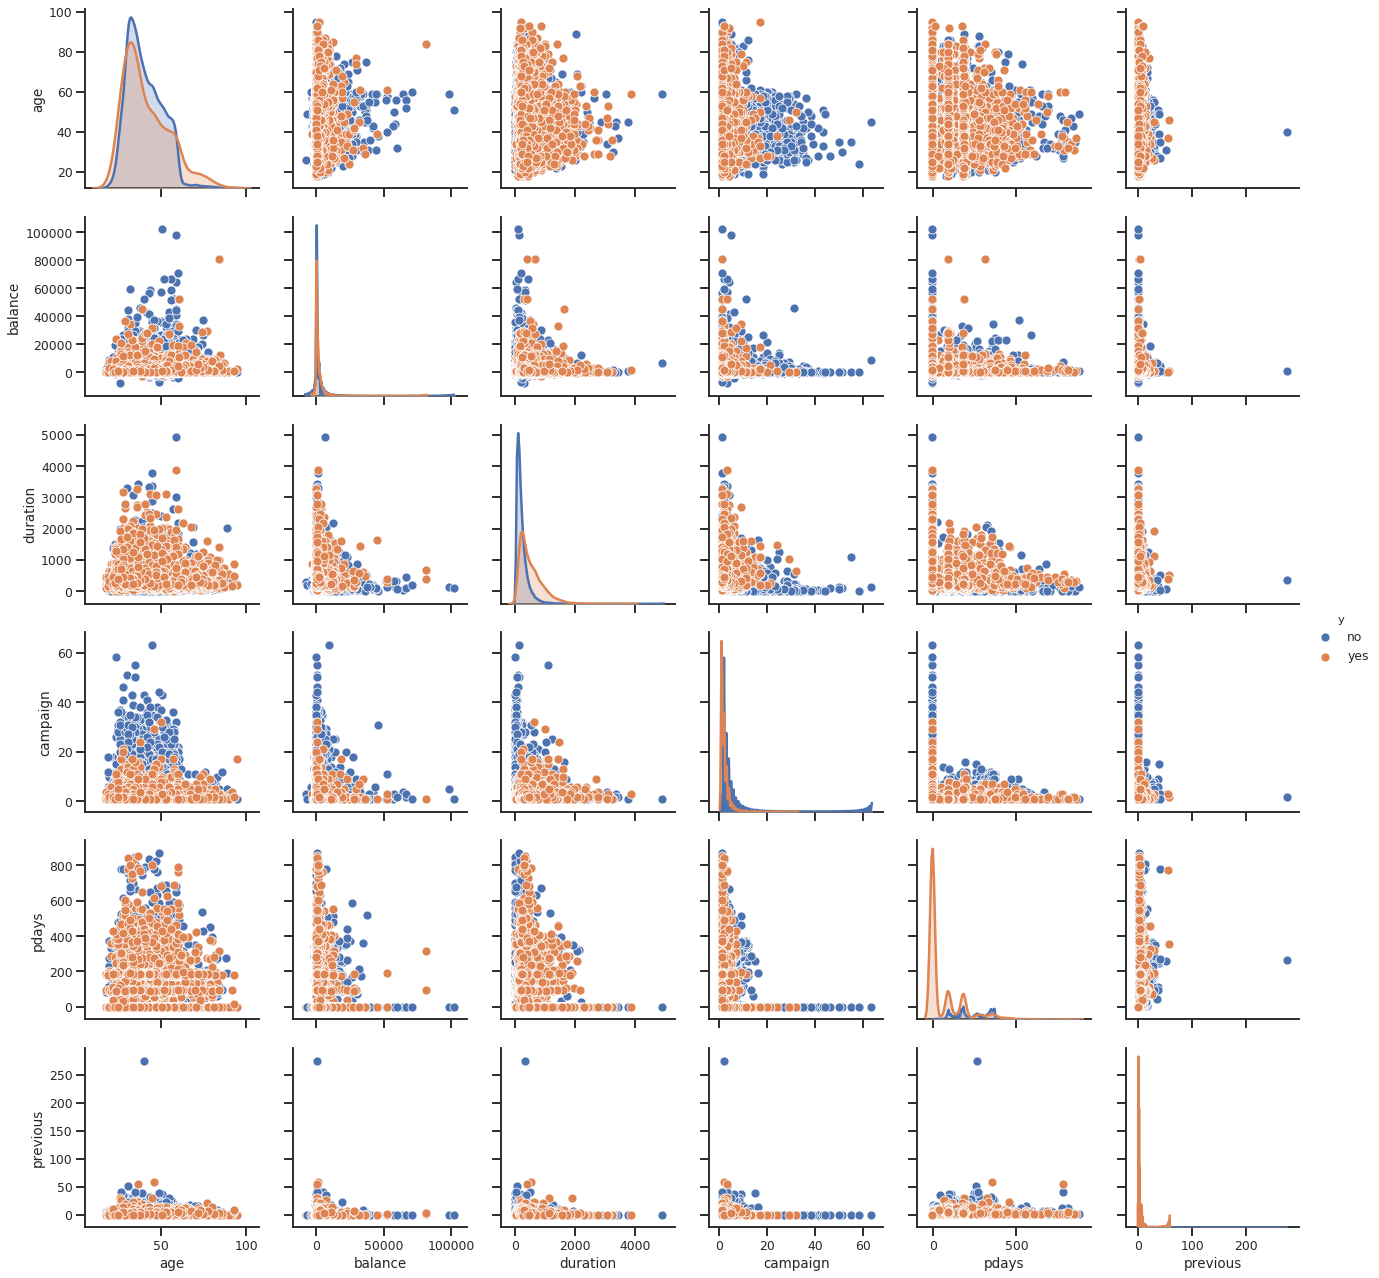

In [8]:
### Let us inspect the numerical feature plots

sns.pairplot(train_df, vars=numerical_features, height=3, 
            diag_kind='kde', hue="y")

#### Observation : 
1. Age is looking okay to proceed forward though not perfectly skewed
2. Campaign and balance looks right skewed - need to study this further
3. pdays and previous - we will hold off in looking too much from these features, need to see if we can form meaninful interaction with combinatioon of campaign, pdays and previous as they are all related to number of contacts made in current and previous campaigns
4. Duration - as stated in problem, increase in duration confirms the target with more bias. Not a recommended feature for model design

In [9]:
#define a plot function of bivariate analysis - Scatter plot

def plot_scatter (graph_df, x_axis, y_axis, target=None):
    
    sns.FacetGrid(graph_df, hue=target, size=5) \
    .map(plt.scatter, x_axis, y_axis) \
    .add_legend()
    
    return;


In [10]:
### Defining KDE plot 

def plot_kde (graph_df, axis, target=None):
    
    sns.FacetGrid(graph_df, hue=target, size=5) \
    .map(sns.kdeplot, axis) \
    .add_legend()
    
    return;

In [11]:
### Defining Boxen Plot for categorical analysis

def plot_boxen(graph_df, x_axis, y_axis):
    
    sns.catplot(x=x_axis, y=y_axis, kind="boxen", data=graph_df)
    return;

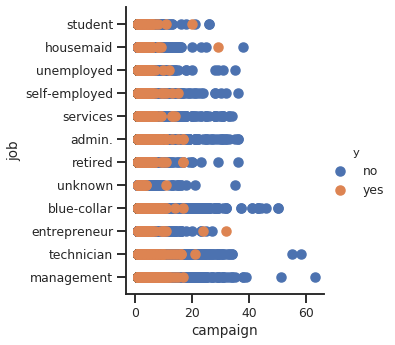

In [12]:
# Plot Campaign Vs Job
plot_scatter(train_df, "campaign", "job", "y")

#### With campaign representing number of contacts duringc current campaign, analyzing this against the job 
#### to assess for any particular patterns


###### Out of various job titles, it is evident from  above plot that few students, housemaid and entreprenur did have some success rates in repeated call attempts to convince the client to subscribe to term deposit. This could also mean that, we can implement a separate model to predict the number of  contacts needed to be successful in the campaign, however it is outside this scope. 

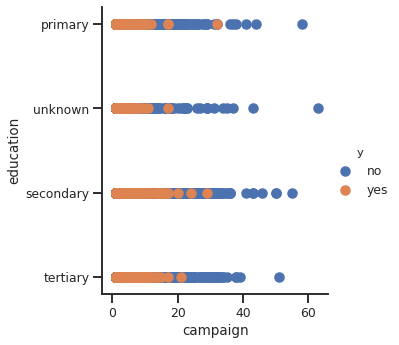

In [13]:
# Campaign Vs Education 

plot_scatter(train_df, "campaign", "education", "y")

###### Primary and secondary education levels seem to have relatively better success rate in terms of subscribing to term deposit

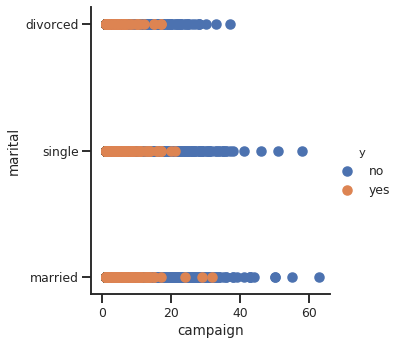

In [14]:
# Status vs Campaign
plot_scatter(train_df, "campaign", "marital", "y")


###### Seems like, Single or Divorced status clients seem to accept to subscribe to term deposit lot sooner than married individuals

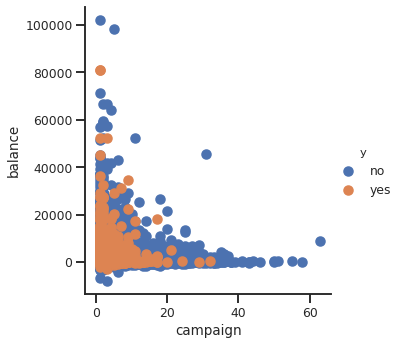

In [15]:
### Campaign Vs Balance
plot_scatter(train_df, "campaign", "balance", "y")


##### Does this ring bells? Though Lower average income population seem to accept for having term deposit, population having higher bank balance have better odds of subscribing to term deposit immediately.

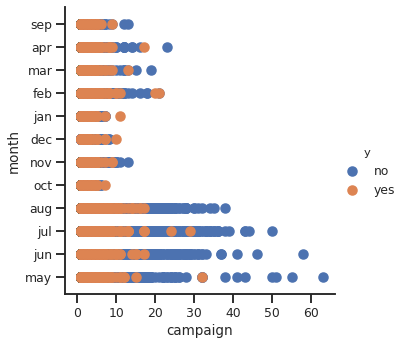

In [16]:
## Plotting campaign vs month
plot_scatter(train_df, "campaign", "month", "y")

##### observations :
1. May, June, July, August months seem to have long campaign by bank for some reasons which we don't know
2. Despite the long campaigns in those 4 months, only May and July seem to have few change of minds from clients to agree to subscribe to term deposits. 

##### Can this be useful strategy insight for the bank? i.e. why conducting longer campaigns if odds are against it? Let us dig into this bit further

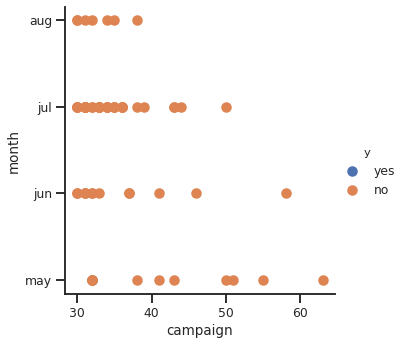

In [17]:
## Plotting campaign vs month AND campaigns > 30
plot_scatter(train_df.query('campaign >= 30'), "campaign", "month", "y")

### Did we just found a data leakage?
i.e. 100% success rate for those 4 months - May, June, July and August if campaigns are conducted for longer time. This may add over bias to the model. We need to be caution with this longer campaigns for these 4 months. 


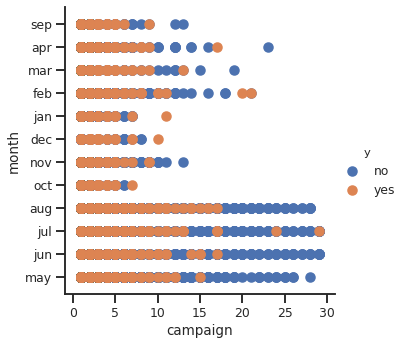

In [18]:
## Plotting campaign vs month AND campaigns < 30 
plot_scatter(train_df.query('campaign < 30'), "campaign", "month", "y")

##### This bank seem to conduct longer campaigns from May till August. 
seems to be some strategical decision from bank which we don't know. 
##### However,
But what we could tell, despite getting more customers to agree to subscribe to term deposits between May and August, success rate for clients to agree to have term deposits is getting better from September and is lot better between October and January. 
#### Bank must definitely be aware of this, as there could be some profit increase for this bank if they spend the campaign money around these months between October and January instead of May - August. 
I do not know in-details about this bank, but what is very evident --> Decision to run campaigns between May and August seems to be trial and error definitely.  

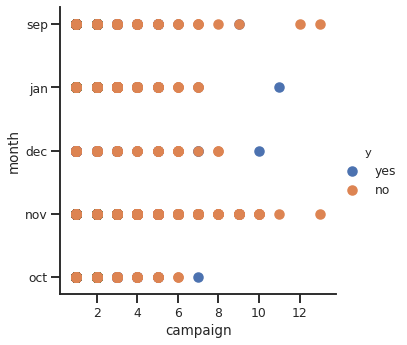

In [19]:
## Plotting campaign vs month AND campaigns < 30 
plot_scatter(train_df.query('campaign < 30')
             .query('month == "sep" or month =="oct" or month == "nov" \
                    or month == "dec" or month == "jan"'),
             "campaign", "month", "y")

##### This confirms our above assessment, i.e. MAXIMUM NUMBER OF CAMPAINS were ONLY 12, and banks should know about this and plan to identify potential customers for longer campaigns.  

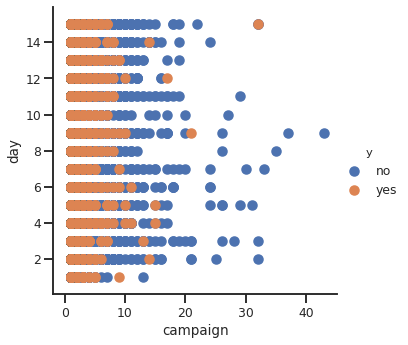

In [20]:
### Now we identified some useful insights around month, let us see if we could find anything for days

### Plotting for first 15 days vs Campaign
plot_scatter(train_df.query('day <= 15'), "campaign", "day", "y")

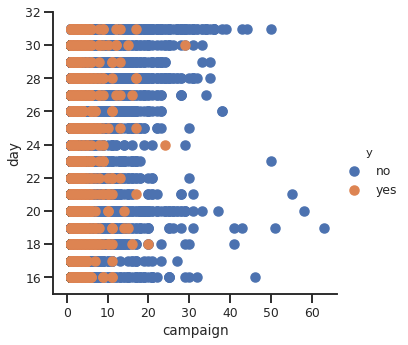

In [21]:
### Plotting for Last 15 days vs Campaign

plot_scatter(train_df.query('day > 15'), "campaign", "day", "y")

#### Definitely this bank has decided, like we saw for months, to have lesser number of campaigns in first 2 weeks & more number of campaigns for last 2 weeks of any month

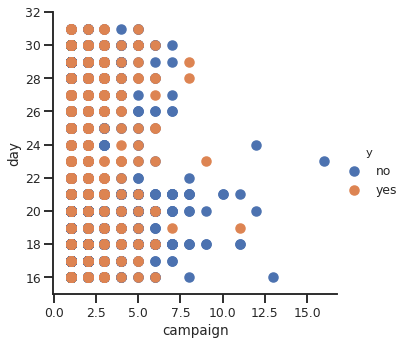

In [22]:
plot_scatter(train_df.query('day > 15 and previous > 0 and previous < 999'),
             "campaign", "day", "y")

##### This is interesting, better success rate in last 15 days, if this client has been contacted in previous campaigns

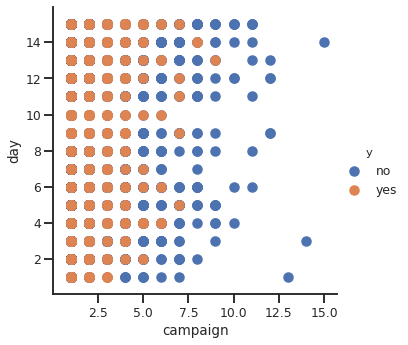

In [23]:
plot_scatter(train_df.query('day <= 15 and previous > 0 and previous < 999'),
             "campaign", "day", "y")

##### confirms above analysis i.e., better success rate in last 15 days, if this client has been contacted in previous campaigns

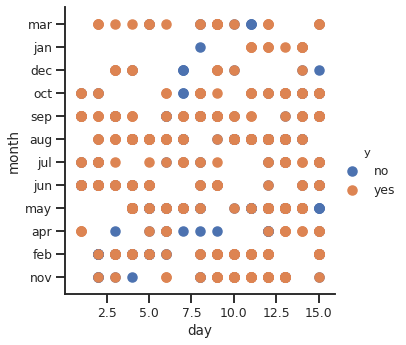

In [24]:
### Trying to see, 
### if we can get any patterns if client has agreed in previous campaigns and if he/she is contacted again

### Plotting when previous campaign was success Vs day/month criteria AND for first 15 days 

plot_scatter(train_df.query('day <= 15 and poutcome == "success"'),
             "day", "month", "y")

##### This seems interesting contradicting the last 15 days of months theory, i.e. if we have clients agreeing to have term deposits in previous campaign, they are most likely to agree to current campaign within shorter number of contacts from bank (precisely and likely to be within first 12-15 contacts). Yes success rate is lot better for previous customers having term deposits.

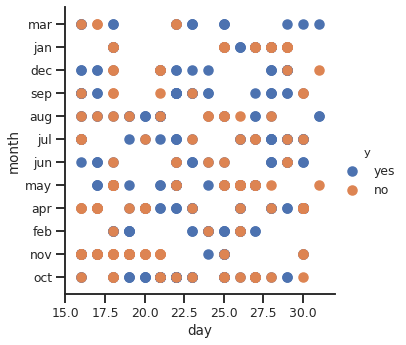

In [25]:
### Plotting when previous campaign was success Vs Last 15 days criteria 

plot_scatter(train_df.query('day > 15 and poutcome == "success"'),
             "day", "month", "y")

###### Above plot does confirm - if we have clients agreeing to have term deposits in previous campaign, they are most likely to agree to current campaign within shorter number of contacts from bank (precisely and likely to be within first 12-15 contacts). Yes success rate is lot better for previous customers having term deposits.

### So, did we just find out - New customers are likely to agree for term deposits if contacted in last 2 weeks of a month and previous customers are likely to agree for term deposits if contacted within first 2 weeks of a month? This insight could save lot of campaign costs for the bank!

In [26]:
### let us investigate this balance - seems to have some negative values as well

print (" Count of people with negative balance: ",train_df.query('balance < 0').count()[0])
train_df.query('balance < 0').head(10).T

 Count of people with negative balance:  3766


,25,28,36,37,45,46,51,53,54,94
age,44,46,25,53,36,58,48,42,24,57
job,admin.,management,blue-collar,technician,admin.,self-employed,management,admin.,technician,entrepreneur
marital,married,single,married,married,single,married,divorced,single,single,divorced
education,secondary,secondary,secondary,secondary,primary,tertiary,tertiary,secondary,secondary,secondary
default,no,no,no,no,no,no,no,no,no,no
balance,-372,-246,-7,-3,-171,-364,-244,-76,-103,-37
housing,yes,yes,yes,no,yes,yes,yes,yes,yes,no
loan,no,no,no,no,no,no,no,no,yes,no
contact,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5,5,5,5,5,5


In [27]:
### 3766 customers, have negative average balance - can this influence the target by any means?

train_df.query('balance < 0 and y == "no"').count()[0]

3556

##### Can this be data leakage? 
i.e. Out of 3776 people, 3556 of them with negative balance did not subscribe to term deposit.
###### i.e. 94% of population with negative balance

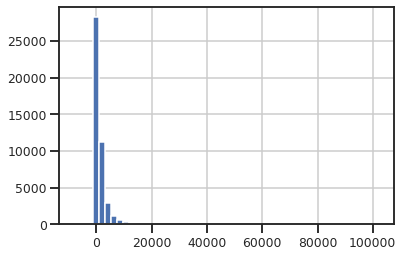

In [28]:
### Plotting the distribution of balance

train_df.balance.hist(bins=50)

In [29]:
train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [30]:
### let us try log transformation of this balance - And add a new feature log_balance for this

train_df['log_balance'] = train_df.balance.map(np.log)

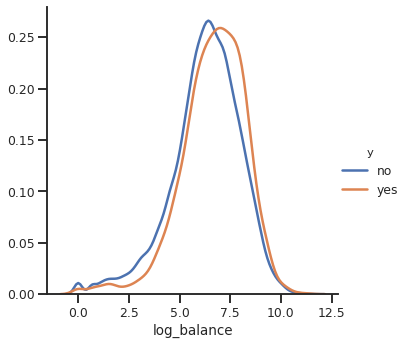

In [31]:
#### Now we can drop balance, and we can use below new feature added 

plot_kde (train_df, "log_balance", target="y")

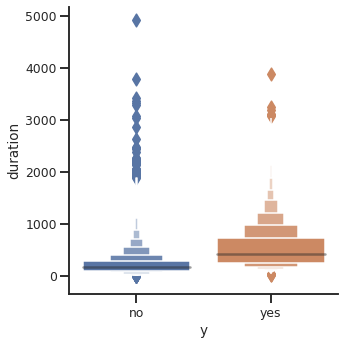

In [32]:
### Though duration has been given in use case as biased feature, 
## I still want to have a look and see how much more biased this feature can be?

plot_boxen(train_df, "y", "duration")

##### There are still people with higher duration calls with NO to term deposits, however this feature can be used as model building like stated in use case

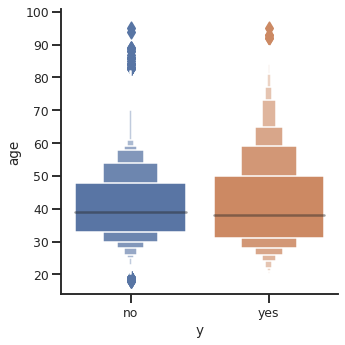

In [33]:
# Age Vs Target 
plot_boxen(train_df, "y", "age")
### Add more business insights #### NOTE

##### Relatively higher aged clients have better success rate of subscribing to term deposit

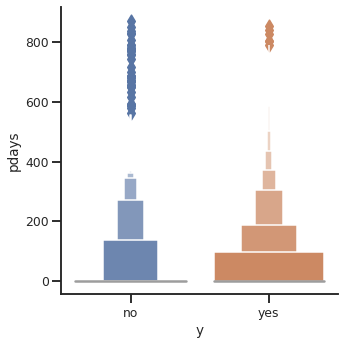

In [34]:
### pdays represent number of days passed after the last contact of this client 
##### pdays vs Target

plot_boxen(train_df, "y", "pdays")

##### More number of days passed, client is unlikely to accept for most of the part to agree to subscribe to term deposit

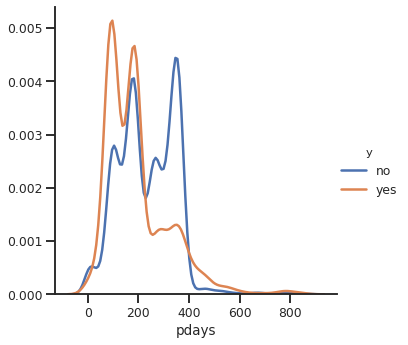

In [35]:
### pdays will be ZERO or 999 for not known values or not contacted clients - Hence eliminating from plot

plot_kde (train_df.query('pdays > 0 and pdays < 999'), "pdays", target="y")

###### Above plot also confirms that, calling back quickly has better success rate for clients to subscribe to term deposit

Text(0.5, 1.0, 'Example of Class Imbalance Problem')

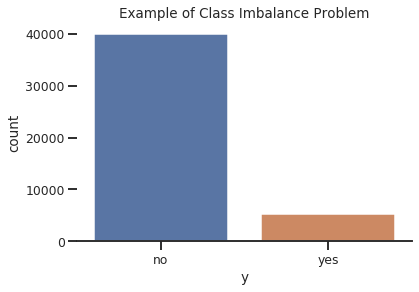

In [36]:
sns_plot = sns.countplot(x="y", data=train_df)
sns.despine(left=True)
plt.title("Example of Class Imbalance Problem")

### create separate df for y == 1 and try to explore more insights why they accept - TO DO

In [37]:
def correlation_matrix(train_df, width=11, height=9, mask_upper=True) :
    # Compute the correlation matrix
    corr = train_df.corr()
    
    if mask_upper == True:
        # Generate a mask for the upper triangle
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    else: 
        mask=None

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(width, height))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    return;

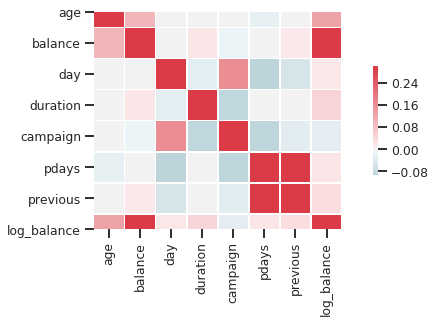

In [38]:
## Computing correlation matrix
correlation_matrix(train_df, 11, 4, False)

In [39]:
# Recap of the features 

print("Numerical features : ", numerical_features)
print("Categorical features: ", categorical_features)
print("Total Features: ",  len(numerical_features) + len(categorical_features))

#Converting object to categorical types -ordered true is needed for pandas filter to work!
for feature in categorical_features :
    train_df[feature] = train_df[feature].astype('category', ordered=True)

train_df.info()

Numerical features :  ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
Categorical features:  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day', 'poutcome']
Total Features:  16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 18 columns):
age            45211 non-null int64
job            45211 non-null category
marital        45211 non-null category
education      45211 non-null category
default        45211 non-null category
balance        45211 non-null int64
housing        45211 non-null category
loan           45211 non-null category
contact        45211 non-null category
day            45211 non-null category
month          45211 non-null category
duration       45211 non-null int64
campaign       45211 non-null int64
pdays          45211 non-null int64
previous       45211 non-null int64
poutcome       45211 non-null category
y              45211 non-null object
log_balance    414

In [40]:
### We are going to retain separate dataframe for encoding
### So that original train_df can be used as backup later if something goes wrong
#### this is recommended as we do not have to read all the dataset from first step especially, our EDA is done

encoded_df = train_df.copy()

In [41]:
encoded_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,log_balance
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,7.669962
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,3.367296
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,0.693147
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,7.317212
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,0.000000


In [42]:
ssss

NameError: name 'ssss' is not defined

In [43]:
#### Converting the categorical features to Dummies

temp_df = pd.get_dummies(encoded_df[categorical_features], prefix=categorical_features)
temp_df.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,day_26,day_27,day_28,day_29,day_30,day_31,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [44]:
####### dropping the irrelavnt original features and concatenating the actual categoricals #######
encoded_df.drop(categorical_features, axis=1, inplace=True)
encoded_df = pd.concat([encoded_df, temp_df], axis=1)
encoded_df.head()

,age,balance,duration,campaign,pdays,previous,y,log_balance,job_admin.,job_blue-collar,...,day_26,day_27,day_28,day_29,day_30,day_31,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,261,1,-1,0,no,7.669962,0,0,...,0,0,0,0,0,0,0,0,0,1
1,44,29,151,1,-1,0,no,3.367296,0,0,...,0,0,0,0,0,0,0,0,0,1
2,33,2,76,1,-1,0,no,0.693147,0,0,...,0,0,0,0,0,0,0,0,0,1
3,47,1506,92,1,-1,0,no,7.317212,0,1,...,0,0,0,0,0,0,0,0,0,1
4,33,1,198,1,-1,0,no,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,1


In [45]:
### Just checking whether original training dataframe is still intact
train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,log_balance
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,7.669962
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,3.367296
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,0.693147
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,7.317212
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,0.000000


In [46]:
#### Scaling the features using Robust Scaler as it provides better handling against outliers ####

from sklearn.preprocessing import RobustScaler
scaled_df = encoded_df[numerical_features].copy()
f_scale = RobustScaler().fit(scaled_df[numerical_features].values)
scaled_df[numerical_features] = f_scale.transform(scaled_df[numerical_features].values)

encoded_df.drop(numerical_features, axis=1, inplace=True)
encoded_df = pd.concat([encoded_df, scaled_df], axis=1)
encoded_df.head()

,y,log_balance,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age,balance,duration,campaign,pdays,previous
0,no,7.669962,0,0,0,0,1,0,0,0,...,0,0,0,1,1.266667,1.250000,0.375000,-0.5,0.0,0.0
1,no,3.367296,0,0,0,0,0,0,0,0,...,0,0,0,1,0.333333,-0.308997,-0.134259,-0.5,0.0,0.0
2,no,0.693147,0,0,1,0,0,0,0,0,...,0,0,0,1,-0.400000,-0.328909,-0.481481,-0.5,0.0,0.0
3,no,7.317212,0,1,0,0,0,0,0,0,...,0,0,0,1,0.533333,0.780236,-0.407407,-0.5,0.0,0.0
4,no,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,1,-0.400000,-0.329646,0.083333,-0.5,0.0,0.0


In [47]:
### Just checking whether original training dataframe is still intact
train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,log_balance
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,7.669962
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,3.367296
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,0.693147
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,7.317212
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,0.000000


In [48]:
### As we have already created log_balance as new feature, let us drop the original balance feature
### Let us also drop duration as well - that is not a useful feature for model design

encoded_df.drop("balance", axis=1, inplace=True)
encoded_df.drop("duration", axis=1, inplace=True)
encoded_df.head()

,y,log_balance,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,day_30,day_31,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age,campaign,pdays,previous
0,no,7.669962,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1.266667,-0.5,0.0,0.0
1,no,3.367296,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.333333,-0.5,0.0,0.0
2,no,0.693147,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,-0.400000,-0.5,0.0,0.0
3,no,7.317212,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.533333,-0.5,0.0,0.0
4,no,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,-0.400000,-0.5,0.0,0.0


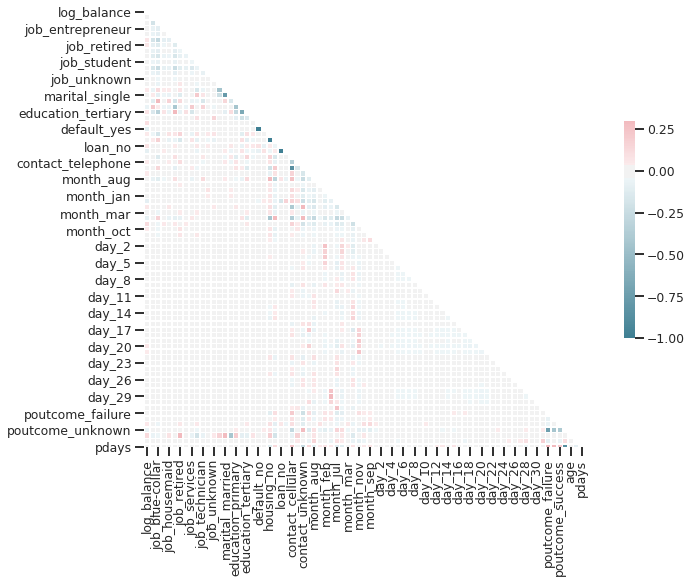

In [52]:
## Computing correlation matrix
correlation_matrix(encoded_df, 12, 8, True)

#### Feature Engineering Readiness: We are going to use 80 features for model design and 1 target for binary classification problem

In [57]:
encoded_df.replace({'no': 0, 'yes': 1}, inplace=True)

### FILTER correlation in separate dataframe between 0.1, 0, -0.1

In [ ]:
#### Split the training data set into X & Y ####
from sklearn import preprocessing
##label_encoder = preprocessing.LabelEncoder() 
##train_df['y']= label_encoder.fit_transform(train_df['y']) 
X = encoded_df.drop('y', axis=1)
y = encoded_df['y']
X.head()

In [ ]:
### CONFIGURING THE BASE MODELS TO TRAIN ###

dict_classifiers = {
    "Logistic Regression": LogisticRegression(n_jobs=-1),    
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_jobs=-1),       
    "AdaBoostClassifier": AdaBoostClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "knn": KNeighborsClassifier(n_jobs=-1)
    }

In [ ]:
###### BASE MODEL TRAINING LOGIC ########

def bulk_train(X_train, Y_train, X_test, Y_test, no_classifiers = 5, verbose = True):
    model_list_pickle = {}
    
    for classifier_name, classifier in list(dict_classifiers.items())[:no_classifiers]:
        start_time = time.clock()
        if verbose:
            print("Training {c} - Start ".format(c=classifier_name))       
        classifier.fit(X_train, np.ravel(Y_train,order='C'))
        end_time = time.clock()        
        total_time_to_train = end_time - start_time
        train_score = classifier.score(X_train, Y_train)
        test_score = classifier.score(X_test, Y_test)
        if verbose:
            print(train_score, test_score)
        
        ############# Also GOING TO CROSS VALIDATE ##############
        from sklearn.model_selection import cross_val_score
        accuracies_cv= cross_val_score(estimator = classifier, X = X_train, y = Y_train, cv = 10)
        accuracies_cv_mean=accuracies_cv.mean()*100
        print("%s : Mean Accuracy from CV is %s %%"%(classifier_name,accuracies_cv_mean))
        accuracies_cv_std=accuracies_cv.std()*100
        print("%s : Standard Deviation from CV %s %%"%(classifier_name,accuracies_cv_std))
        ################# END OF CROSS VALIDATE #################
        
        model_list_pickle[classifier_name] = {'model': classifier, 
                                              'train_score': train_score, 
                                              'test_score': test_score, 
                                              'train_time': total_time_to_train,
                                              'crossval_avg_accuracy': accuracies_cv_mean,
                                              'crossval_std': accuracies_cv_std
                                             }
        
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=classifier_name, f=total_time_to_train))
            
    return model_list_pickle

In [ ]:
#### FUNCTION TO RECORD MODEL METRICS AS DATAFRAME ###

def print_confusion_matrix(model_list, X_test):
    cls_key = [key for key in model_list.keys()]
    cm_df_values = [[]]
    cm_df_cols = ['classifer', 'True_Positive', 'True_Negative', 'False_Postive', 'False_Negative',
                  'Train_AccuracyScore','Test_AccuracyScore', 'CrossVal_Accuracy%', 'CrossVal_STD']
    for i in range(0, len(cls_key)):
        predictions = model_list[cls_key[i]]['model'].predict(X_test)
        cm = confusion_matrix(y_test, predictions)
        cr = classification_report(y_test, predictions)
        print("\n###### Confusion Matrix Summary for [%s] ######\n"%(cls_key[i]))
        print(cm)
        print("\n###### Classification Report for [%s] ######\n"%(cls_key[i]))
        print(cr)
        if (i == 0) :
            cm_df_values = [[cls_key[i], cm[1,1], cm[0,0], cm[0,1], cm[1,0],
                            model_list[cls_key[i]]['train_score'], model_list[cls_key[i]]['test_score'],
                            model_list[cls_key[i]]['crossval_avg_accuracy'], model_list[cls_key[i]]['crossval_std']]]
        else :            
            cm_df_values = cm_df_values + [[cls_key[i], cm[1,1], cm[0,0], cm[0,1], cm[1,0],
                                           model_list[cls_key[i]]['train_score'], model_list[cls_key[i]]['test_score'],
                                           model_list[cls_key[i]]['crossval_avg_accuracy'], model_list[cls_key[i]]['crossval_std']]]
       
    cm_df = pd.DataFrame(data=cm_df_values, columns=cm_df_cols)
    print("\n###### Exiting Confusion Matrix Summary ######\n")
    return cm_df

In [ ]:
def log_train_summary(model_list, sort_by='test_score'):
    cls_key = [key for key in model_list.keys()]
    test_local = [model_list[key]['test_score'] for key in cls_key]
    training_local = [model_list[key]['train_score'] for key in cls_key]
    training_time_local = [model_list[key]['train_time'] for key in cls_key]
    
    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls_key),4)), columns = ['classifier', 'train_score', 'test_score', 'train_time'])
    for i in range(0,len(cls_key)):
        df_.loc[i, 'classifier'] = cls_key[i]
        df_.loc[i, 'train_score'] = training_local[i]
        df_.loc[i, 'test_score'] = test_local[i]
        df_.loc[i, 'train_time'] = training_time_local[i]
    
    #overriding the sort clause passed in function to get list of sort criteria for now
    print(df_.sort_values(by=['test_score','train_score'], ascending=False))

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

In [ ]:
### Number of records with class 1
train_df.query('y == 1').count()[1]

In [ ]:
### Number of records with class 0
train_df.query('y == 0').count()[1]

In [ ]:
# Recollecting the population of target

plt.figure(figsize=(10, 4))
sns.countplot(y)
plt.show()

##### Clearly class imbalance problem

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
# We will resample using SMOTE to generate more samples of minority class

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [ ]:
# After resampling - Let us verify whether we have equal weight on target class in train
## TO BE NOTED - DO NOT APPLY ON TEST DATA
#######################################################
plt.figure(figsize=(10, 4))
sns.countplot(y_res)
plt.show()

#### Like you can see, it has reduced the majority class(class 0) and boosted the minority class(class 1). This would be apt for training. 

In [ ]:
### Training with Different BASE Models #######################################
##### To be noted - Resampled training samples should be passed to model ######
##### And Original test data has to be passed -- DO NOT SAMPLE TEST DATE ######
###############################################################################

models_list = bulk_train(X_res, y_res, X_test, y_test, no_classifiers = 6, verbose=False)
print("\n")
print("############ CONSOLIDATED MODEL TRAINING SUMMARY ############")
print("############### ######################## ###################")
log_train_summary(models_list)
print("############### ######################## ###################")

In [ ]:
print("############### ######################## ###################")
#### Printing Confusion Matrix #####
confusion_matrix_df = print_confusion_matrix(models_list, X_test)

In [ ]:
confusion_matrix_df

In [ ]:
###############################################################
#Hyper parameter tuning between 2 classification models #######
### choosing Logistics Regression & Random Forest because #####
######### these 2 models have consistently did better #########
############ based on above evaluation summary ################
###############################################################

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
n_folds = 5
pipe = Pipeline([('model_gs' , LogisticRegression())])

param_grid_logisticsRegression = [
    {'model_gs' : [LogisticRegression(class_weight='balanced')],
     'model_gs__penalty' : ['l2'],
     'model_gs__C' : [0.001, 0.01, 0.1, 
                      1, 10, 40, 50, 200],
    'model_gs__solver' : ['liblinear']}
]


#choosing njobs as -1 to have parallel processing
grid = GridSearchCV(pipe, param_grid = param_grid_logisticsRegression,cv = n_folds, verbose=True, n_jobs=-1)

In [ ]:
def plot_crossval_grap(best_grid_search_model, x_range) :
    ### Extract mean score, standard deviation from the best fit model ###
    scores_avg = np.array(best_grid_search_model.cv_results_['mean_test_score'])
    scores_std = best_grid_search_model.cv_results_['std_test_score']
    ### This is masked array, hence we need to use filled to convert this to normal array
    x_crange = best_grid_search_model.cv_results_[x_range].filled()
    std_error = scores_std / np.sqrt(n_folds)
    
    scores_avg = np.array(best_grid_search_model.cv_results_['mean_test_score'])
    #print(scores_avg.shape)
    scores_std = best_grid_search_model.cv_results_['std_test_score']
    ### This is masked array, hence we need to use filled to convert this to normal array
    x_crange = best_grid_search_model.cv_results_[x_range].filled()
    #print(x_crange.shape)
    std_error = scores_std / np.sqrt(n_folds)
    plt.figure().set_size_inches(12, 10)
    plt.semilogx(x_crange, scores_avg)
    
    plt.semilogx(x_crange, scores_avg + std_error, 'r--')
    plt.semilogx(x_crange, scores_avg - std_error, 'r--')
    plt.ylabel('CV score +/- std error')
    plt.xlabel('Range of C - Plotting GridSearch CV')
    plt.axhline(np.max(scores_avg), linestyle='--', color='green')
    plt.xlim([x_crange[0], x_crange[-1]])

In [ ]:
best_clf_1 = grid.fit(X_res, y_res)
plot_crossval_grap(best_clf_1,'param_model_gs__C')
best_clf_1.best_estimator_
print("Best Estimator : ", best_clf_1.best_estimator_)
print("Training Score : %.4f"%(best_clf_1.score(X_res, y_res)))
print("Testing Score : %.4f"%(best_clf_1.score(X_test, y_test)))

## TO DO for problem to be complete

1. LR with all hyper parameters
2. KNN with optimal value of K
3. Decision Tree with GINI/Entropy, and try with pruning based on outcome
4. Decision Tree - Other hyper parameter tuning
5. Random Forest with hyper paramters with nestimators - 64 to 128, based on research
6. XGB boost hyper parameter tuning
7. Catboost hyper parameter tuning
8. LightGBM hyper parameter tuning
9. Stacking and blending
10. Voting classifier, Bagging Estimator - Can also try with Ada, GB

##### Put together a technical/non technical summary of thought process in beginning like a solution/approach summary
Recap the important strategy insights in terms of business - i.e. outcomes captured from EDA

In [ ]:
param_grid_trees = [
    {'model_gs' : [RandomForestClassifier(class_weight='balanced')],
     'model_gs__max_depth': [24, 32, 40],     
     'model_gs__min_samples_leaf': [1, 2],
     'model_gs__n_estimators': [25, 250,300, 350], ### 
     'model_gs__n_jobs':[-1], 
     'model_gs__random_state':[123]}
]
param_grid_trees

In [ ]:
grid_rf = GridSearchCV(pipe, param_grid = param_grid_trees,cv = n_folds, verbose=True, n_jobs=-1)
best_clf_rf = grid_rf.fit(X_res, y_res)

In [ ]:
from sklearn.metrics import roc_auc_score
plot_crossval_grap(best_clf_rf, 'param_model_gs__n_estimators')
print("Best Estimator : ", best_clf_rf.best_estimator_)
print("Training Score : %.4f"%(best_clf_rf.score(X_res, y_res)))
print("Testing Score : %.4f"%(best_clf_rf.score(X_test, y_test)))

In [ ]:
########## True, Negatives, False Positives, True Positives, False Negatives of Random Forest###
####################### Post Grid Search Optimizations #########################################
grid_rf_pred = best_clf_rf.predict(X_test)
print(confusion_matrix(y_test, grid_rf_pred))
print(classification_report(y_test, grid_rf_pred))

y_pred_proba = best_clf_rf.predict_proba(X_test)
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred_proba[:,1]))
#AUC curve of Random Forest
generate_auc_roc_curve(best_clf_rf, X_test)

In [ ]:
from sklearn.ensemble import VotingClassifier
####################################################
## Bagging on multiple classifier - VOTING CLASSIFIER
#####################################################
##### We are using Logistics Regression, KNN from non-tree algorithms and #######
##### Decion Tree, Random Forest and XGB from Tree algorithms. ##################
##### This is mainly because, we have feature tranformed and encoded ############
##### categorical feature and I want to have both tree and non tree based #######
##### in this mix to form a strong classifier together ##########################
#################################################################################

clf1 = LogisticRegression()
clf2=KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2, n_jobs=-1)
clf3=DecisionTreeClassifier(criterion = 'entropy')
clf4=RandomForestClassifier(n_estimators = 500, n_jobs=-1, criterion = 'entropy')
clf5=XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

voting_clf = VotingClassifier( \
    estimators= [('lr',clf1), 
                 ('knn',clf2), 
                 ('dt',clf3), 
                 ('rf',clf4),
                ('xgb',clf5)], voting = 'hard')
voting_clf.fit(X_res,y_res)


In [ ]:
from sklearn.model_selection import cross_val_score 
vc_xval= cross_val_score(estimator = voting_clf, X = X_train, y = y_train, cv = 10) 
vc_xval_mean=vc_xval.mean()*100
vc_xval_std=vc_xval_mean.std()*100

print("Cross Validation Training Score of Voting Classifier : ",vc_xval_mean)
print("Standard Deviation of Voting Classifier :",vc_xval_std)


In [ ]:
############ Stacking Classifier ###############

#### Obtained Logistic Regression Model through Hyper parameter tuning ####

clf_lr = LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

#### Obtained Random Forest Regression Model through Hyper parameter tuning ####

clf_rf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=40, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=350, n_jobs=-1, oob_score=False, random_state=123,
            verbose=0, warm_start=False)

#### obtained XGB Model through hyper paramter tuning ########

clf_xgb = XGBClassifier( learning_rate =0.1,  n_estimators=1000,  max_depth=5, 
                        min_child_weight=1,  gamma=0,  subsample=0.8,  colsample_bytree=0.8, 
                        objective= 'binary:logistic',  nthread=4, scale_pos_weight=1, seed=27)


clf_knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

clf_ada =  AdaBoostClassifier()
clf_gb = GradientBoostingClassifier()

In [ ]:
### Performing Stacking using vecstack package in python #######
from vecstack import stacking
from sklearn.metrics import log_loss
models = [clf_lr, clf_rf, clf_xgb, clf_knn, clf_ada, clf_gb] 

S_train, S_test = stacking(models, X_res, y_res, X_test, regression=False,
                           mode='oof_pred_bag', 
                           needs_proba=False, save_dir=None,
                           metric=log_loss, n_folds=4, stratified=True,
                           shuffle=True,
                           random_state=0, verbose=2)

##### Outcome of Stacking : 
We have now used 6 models as first level of stacking. We can extend this to multiple levels with different combinations and construct few more level of stacking. This would lead to generalized model implementation for production 

In [ ]:
level2_clf = LogisticRegression(n_jobs=-1)
level2_clf.fit(S_train, y_res)


In [ ]:
from sklearn.metrics import accuracy_score

stack_pred = level2_clf.predict(S_test)
print('Stacking prediction of UNSEEN TEST DATA score: [%.3f]' % accuracy_score(y_test, stack_pred))

## Also measure the F1 score, AUC score for stacking - to conclude the measure

#### Conclusion :
1. After applying stacking - it is very evident that model's test accuracy score is higher compared to the base test score from base models before stacking
2. This implies, Model built with ensembling has 89% confidence in identifying the clients who would subscribe to the term deposit